## 準備
著者サイトで公開されているデータを使います。

http://hosho.ees.hokudai.ac.jp/~kubo/ce/IwanamiBook.html

In [35]:
import requests
import zipfile
import math
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
%precision 3

'%.3f'

In [4]:
# 全カラムを表示させる
pd.set_option('display.max_columns', None)

## 8.1 例題：種子の生存確率(個体差なし)

In [18]:
data = pd.DataFrame(data=[4,3,4,5,5,2,3,1,4,0,1,5,5,6,5,4,4,5,3,4], columns=['y'])
data['N'] = np.ones(20, dtype=np.int) * 8

data

,y,N
0,4,8
1,3,8
2,4,8
3,5,8
4,5,8
5,2,8
6,3,8
7,1,8
8,4,8
9,0,8


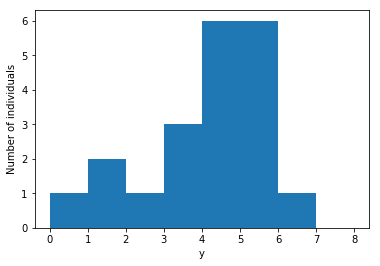

In [153]:
# ヒストグラム
plt.hist(data['y'], bins=range(9))
plt.xlabel('y')
plt.ylabel('Number of individuals')
plt.show()

In [20]:
# 二項分布にしたがうとして、y=β1の線形予測子とロジットリンク関数でモデルを作成
result = smf.glm(formula='y + I(N-y) ~ 1', data=data, family=sm.families.Binomial()).fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      ['y', 'I(N - y)']   No. Observations:                   20
Model:                            GLM   Df Residuals:                       19
Model Family:                Binomial   Df Model:                            0
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -37.748
Date:                Tue, 20 Feb 2018   Deviance:                       28.722
Time:                        09:30:04   Pearson chi2:                     24.5
No. Iterations:                     5                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -0.1754      0.159     -1.105      0.269        -0.487     0.136
==============================================================================
"""

In [26]:
print('最尤推定値:', 1 / (1 + math.exp(-result.params['Intercept'])))

最尤推定値: 0.45624999999999993


## 8.2 ふらふら試行錯誤による最尤推定

In [94]:
def loglikelihood(data, q):
    ll = 0
    
    for i, r in data.iterrows():
        ll = ll + math.log(scipy.misc.comb(r['N'], r['y'])) + r['y']*math.log(q) + (r['N'] - r['y'])*math.log(1 - q)
        
    return ll

def maximum_likelihood_estimation(data, q_start, number_of_trials):
    q_current = q_start
    ll_current = loglikelihood(data, q_current)
    
    q = [q_current]
    ll = [ll_current]
    
    for r in np.random.random(number_of_trials):
        q_new = q_current + 0.01 if r > 0.5 else q_current - 0.01
        ll_new = loglikelihood(data, q_new)
        
        if ll_current < ll_new:
            q_current = q_new
            ll_current = ll_new
            
        q.append(q_current)
        ll.append(ll_current)
    
    return q, ll

q_03, ll_03 = maximum_likelihood_estimation(data, 0.3, 100)
q_06, ll_06 = maximum_likelihood_estimation(data, 0.6, 100)

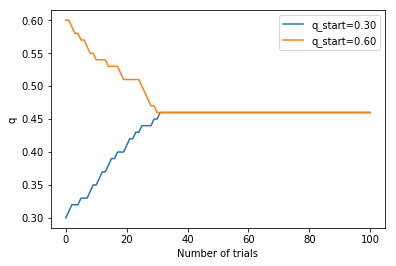

In [101]:
# 推定する過程をプロット
plt.plot(np.arange(len(q_03)), q_03, label='q_start=0.30')
plt.plot(np.arange(len(q_06)), q_06, label='q_start=0.60')
plt.legend()
plt.xlabel('Number of trials')
plt.ylabel('q')
plt.show()

In [104]:
# 試行回数100回目のqと最尤推定値
print('q:', q_03[100])
print('対数尤度:', ll_03[100])

q: 0.46000000000000013
対数尤度: -37.7523669907


## 8.3 MCMCアルゴリズムのひとつ：メトロポリス法

In [109]:
# MCMC(メトロポリス法)
def mcmc_metropolis(data, q_start, number_of_trials):
    q_current = q_start
    ll_current = loglikelihood(data, q_current)
    
    q = [q_current]
    ll = [ll_current]
    
    for r1, r2 in zip(np.random.random(number_of_trials), np.random.random(number_of_trials)):
        q_new = q_current + 0.01 if r1 > 0.5 else q_current - 0.01
        if q_new <= 0.01:
            q_new = 0.02
        elif q_new >= 0.99:
            q_new = 0.98
        ll_new = loglikelihood(data, q_new)
        
        if ll_current < ll_new or (math.exp(ll_new - ll_current)  > r2):
            q_current = q_new
            ll_current = ll_new
            
        q.append(q_current)
        ll.append(ll_current)
    
    return q, ll

q_100, ll_100 = mcmc_metropolis(data, 0.3, 100)
q_1000, ll_1000 = mcmc_metropolis(data, 0.3, 1000)
q_10000, ll_10000 = mcmc_metropolis(data, 0.3, 10000)
q_100000, ll_100000 = mcmc_metropolis(data, 0.3, 100000)

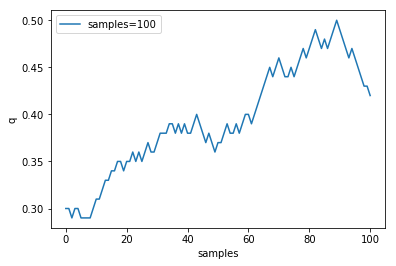

In [145]:
# サンプル数100
plt.plot(np.arange(len(q_100)), q_100, label='samples=100')
plt.legend()
plt.xlabel('samples')
plt.ylabel('q')
plt.show()

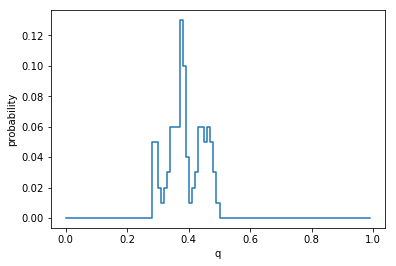

In [192]:
# サンプル数100におけるqの確率分布
count, value = np.histogram(q_100, bins=100, range=(0.00, 1.00))
plt.step(value[:-1], count/100)
plt.xlabel('q')
plt.ylabel('probability')
plt.show()

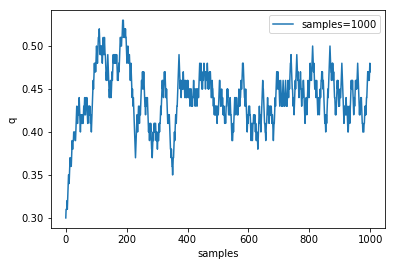

In [146]:
# サンプル数1000
plt.plot(np.arange(len(q_1000)), q_1000, label='samples=1000')
plt.legend()
plt.xlabel('samples')
plt.ylabel('q')
plt.show()

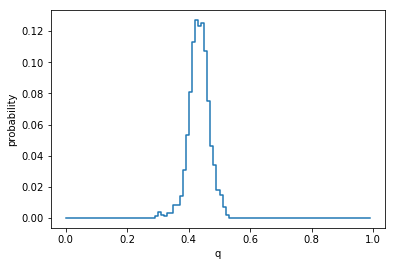

In [193]:
# サンプル数1000におけるqの確率分布
count, value = np.histogram(q_1000, bins=100, range=(0.00, 1.00))
plt.step(value[:-1], count/1000)
plt.xlabel('q')
plt.ylabel('probability')
plt.show()

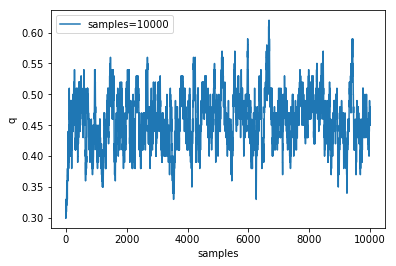

In [147]:
# サンプル数10000
plt.plot(np.arange(len(q_10000)), q_10000, label='samples=10000')
plt.legend()
plt.xlabel('samples')
plt.ylabel('q')
plt.show()

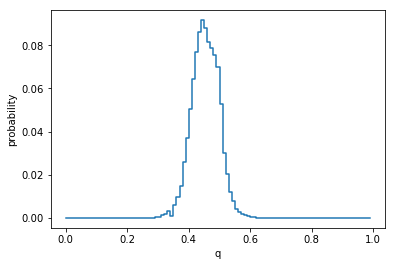

In [194]:
# サンプル数1000におけるqの確率分布
count, value = np.histogram(q_10000, bins=100, range=(0.00, 1.00))
plt.step(value[:-1], count/10000)
plt.xlabel('q')
plt.ylabel('probability')
plt.show()

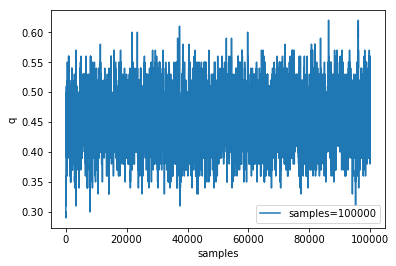

In [151]:
# サンプル数100000
plt.plot(np.arange(len(q_100000)), q_100000, label='samples=100000')
plt.legend()
plt.xlabel('samples')
plt.ylabel('q')
plt.show()

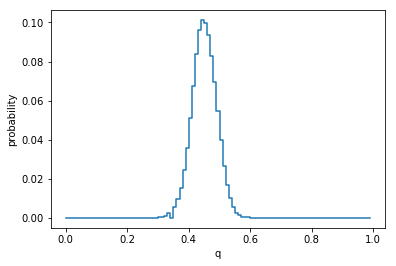

In [195]:
# サンプル数100000におけるqの確率分布
count, value = np.histogram(q_100000, bins=100, range=(0.00, 1.00))
plt.step(value[:-1], count/100000)
plt.xlabel('q')
plt.ylabel('probability')
plt.show()

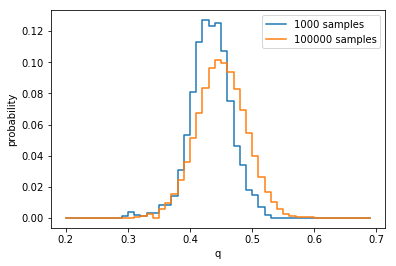

In [208]:
# サンプル数1000と100000でqの確率分布を比較
count, value = np.histogram(q_1000, bins=100, range=(0.00, 1.00))
plt.step(value[20:70], count[20:70]/1000, label='1000 samples')
count, value = np.histogram(q_100000, bins=100, range=(0.00, 1.00))
plt.step(value[20:70], count[20:70]/100000, label='100000 samples')
plt.legend()
plt.xlabel('q')
plt.ylabel('probability')
plt.show()

In [131]:
q_01, ll_01 = mcmc_metropolis(data, 0.1, 500)
q_04, ll_04 = mcmc_metropolis(data, 0.4, 500)
q_06, ll_06 = mcmc_metropolis(data, 0.6, 500)
q_09, ll_09 = mcmc_metropolis(data, 0.9, 500)

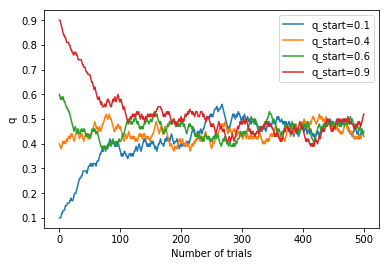

In [132]:
plt.plot(np.arange(len(q_01)), q_01, label='q_start=0.1')
plt.plot(np.arange(len(q_04)), q_04, label='q_start=0.4')
plt.plot(np.arange(len(q_06)), q_06, label='q_start=0.6')
plt.plot(np.arange(len(q_09)), q_09, label='q_start=0.9')
plt.legend()
plt.xlabel('Number of trials')
plt.ylabel('q')
plt.show()